## Importando bibliotecas e base

In [8]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import periodogram, detrend

from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import shap 

from typing import Optional,Dict,Tuple
from pathlib import Path

from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, LocalStandardScaler

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mae, coverage, mase

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
from mlforecast.target_transforms import Differences, AutoDifferences, LocalBoxCox, GlobalSklearnTransformer
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

from bcb import sgs
import os

from sklearn.preprocessing import FunctionTransformer
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# plots setup
# https://medium.com/@tttgm/styling-charts-in-seaborn-92136331a541
plt.rcParams.update(**{'figure.dpi': 150})
# color palette can be passed as a list of hex codes
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# set overall plot style, font size scaling factor, and color palette
sns.set(style="whitegrid", font_scale=1, palette=custom_colors)
warnings.filterwarnings("ignore", "use_inf_as_na") # issue with seaborn

In [9]:
df = sgs.get({'IPCA': 433}, start='2015-01-01', end='2025-05-01')
df = df.reset_index()

In [10]:
df.head()

,Date,IPCA
0,2015-01-01,1.24
1,2015-02-01,1.22
2,2015-03-01,1.32
3,2015-04-01,0.71
4,2015-05-01,0.74


In [11]:
df['ds'] = df['Date']
df = df[['ds', 'IPCA']]

df['unique_id'] = 1

df.head()

,ds,IPCA,unique_id
0,2015-01-01,1.24,1
1,2015-02-01,1.22,1
2,2015-03-01,1.32,1
3,2015-04-01,0.71,1
4,2015-05-01,0.74,1


In [12]:
# Preprocessing to Nixtla format
df['y'] = df.IPCA
df = df[['unique_id', 'ds', 'y']]
df.head()

,unique_id,ds,y
0,1,2015-01-01,1.24
1,1,2015-02-01,1.22
2,1,2015-03-01,1.32
3,1,2015-04-01,0.71
4,1,2015-05-01,0.74


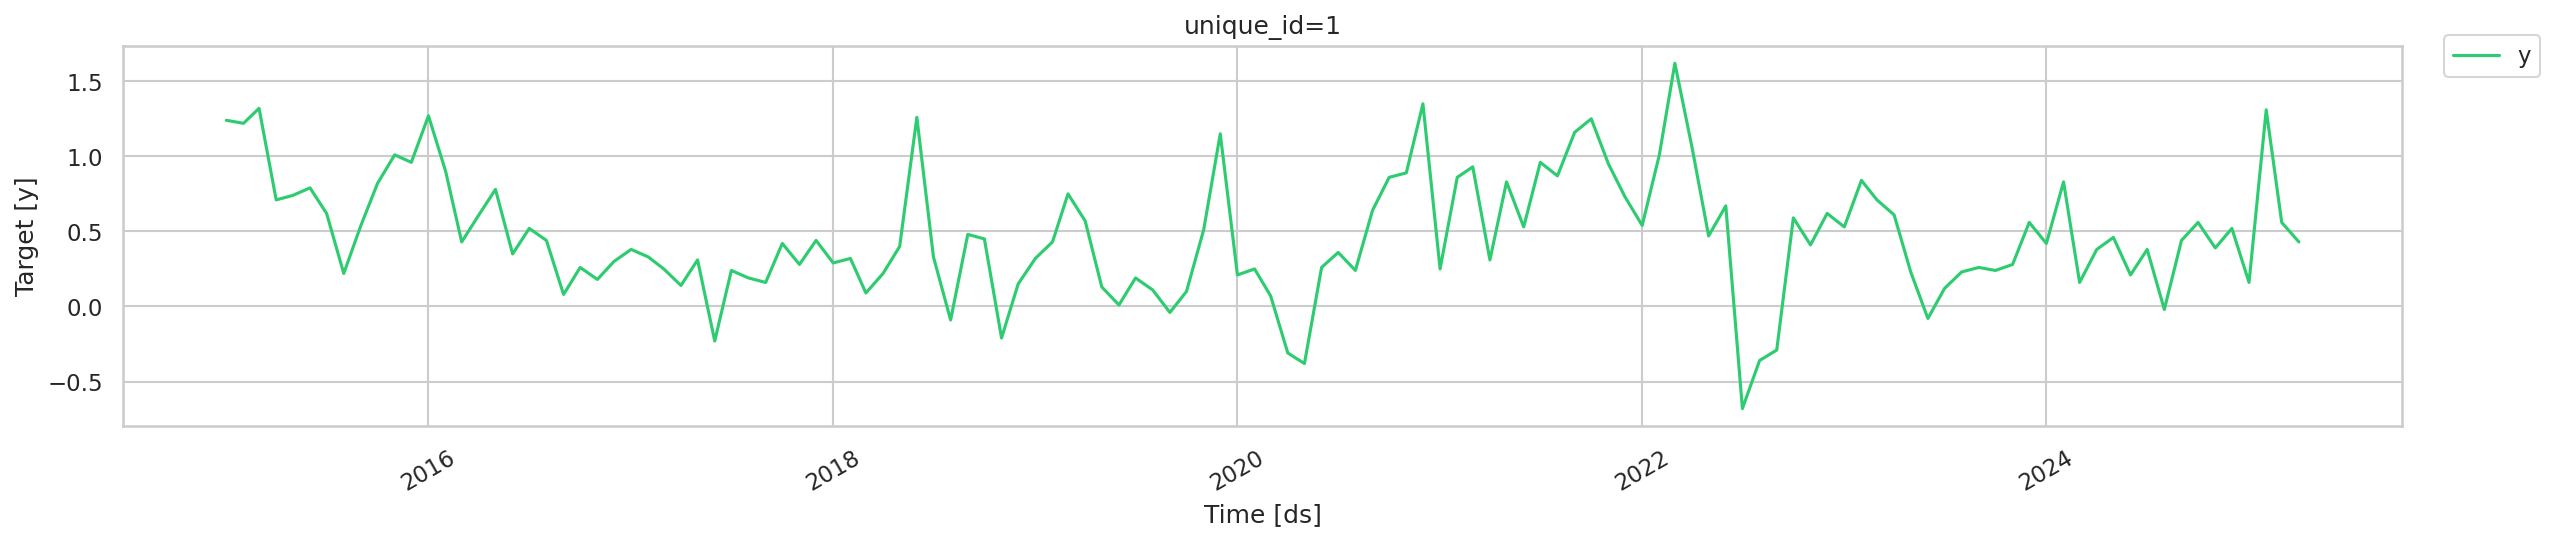

In [13]:
# Plotting the series
fig = plot_series(df)
fig

In [14]:
from statsmodels.tsa.stattools import adfuller
serie = df[df['unique_id'] == 1].sort_values('ds')['y']

# Aplicar o teste ADF
resultado = adfuller(serie)

# Exibir os resultados
print('Estatística ADF:', resultado[0])
print('Valor-p:', resultado[1])
print('Nº de lags usados:', resultado[2])
print('Nº de observações:', resultado[3])
print('Valores críticos:')
for chave, valor in resultado[4].items():
    print(f'   {chave}: {valor}')


Estatística ADF: -6.2412020202613565
Valor-p: 4.692575773964238e-08
Nº de lags usados: 0
Nº de observações: 123
Valores críticos:
   1%: -3.4846672514209773
   5%: -2.8853397507076006
   10%: -2.5794629869786503


#### Train/Test splint

In [15]:
# ## Train-test split
# We will use the last 12 months as the test set.

df_train = df[df.ds < '2024-06-01']
df_test = df[df.ds >= '2024-06-01']

In [59]:
models  = [
    CatBoostRegressor(n_estimators=200, random_state=42, verbose=False),
]
fcst = MLForecast(
    models=models,
    freq='MS',  # our serie has a monthly frequency
    lags=[12, 6, 3, 1],
    
    lag_transforms={
        1: [
            ExpandingMean(),
            RollingMean(window_size=3),
            RollingMean(window_size=6),
            RollingMean(window_size=12),
            RollingStd(window_size=3),
            RollingStd(window_size=6),
            RollingStd(window_size=12),
        ],
        3: [
            ExpandingMean(),
        ],
    },
    date_features=['month', 'quarter'] 
)



In [60]:
# Fit the forecast model
df_train_prep = fcst.preprocess(df_train)
df_train_prep.head()

,unique_id,ds,y,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter
12,1,2016-01-01,1.27,1.24,0.62,0.82,0.96,0.849167,0.930000,0.695000,0.849167,0.098489,0.296766,0.320467,0.822000,1,1
13,1,2016-02-01,0.90,1.22,0.22,1.01,1.27,0.881538,1.080000,0.803333,0.851667,0.166433,0.372809,0.323892,0.839091,2,1
14,1,2016-03-01,0.43,1.32,0.54,0.96,0.90,0.882857,1.043333,0.916667,0.825000,0.198578,0.239555,0.303330,0.849167,3,1
15,1,2016-04-01,0.61,0.71,0.82,1.27,0.43,0.852667,0.866667,0.898333,0.750833,0.420991,0.275639,0.279137,0.881538,4,2
16,1,2016-05-01,0.78,0.74,1.01,0.90,0.61,0.837500,0.646667,0.863333,0.742500,0.237136,0.299844,0.281945,0.882857,5,2


#### Train a single model and use the recursive strategy

In [61]:
fcst.fit(
    df_train,
    # https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html
    prediction_intervals=PredictionIntervals(n_windows=3, h=12, method="conformal_distribution")
)

MLForecast(models=[CatBoostRegressor], freq=MS, lag_features=['lag12', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_std_lag1_window_size6', 'rolling_std_lag1_window_size12', 'expanding_mean_lag3'], date_features=['month', 'quarter'], num_threads=1)

In [62]:
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)
df_train_prep.head()

,lag12,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_std_lag1_window_size6,rolling_std_lag1_window_size12,expanding_mean_lag3,month,quarter
12,1.24,0.62,0.82,0.96,0.849167,0.930000,0.695000,0.849167,0.098489,0.296766,0.320467,0.822000,1,1
13,1.22,0.22,1.01,1.27,0.881538,1.080000,0.803333,0.851667,0.166433,0.372809,0.323892,0.839091,2,1
14,1.32,0.54,0.96,0.90,0.882857,1.043333,0.916667,0.825000,0.198578,0.239555,0.303330,0.849167,3,1
15,0.71,0.82,1.27,0.43,0.852667,0.866667,0.898333,0.750833,0.420991,0.275639,0.279137,0.881538,4,2
16,0.74,1.01,0.90,0.61,0.837500,0.646667,0.863333,0.742500,0.237136,0.299844,0.281945,0.882857,5,2


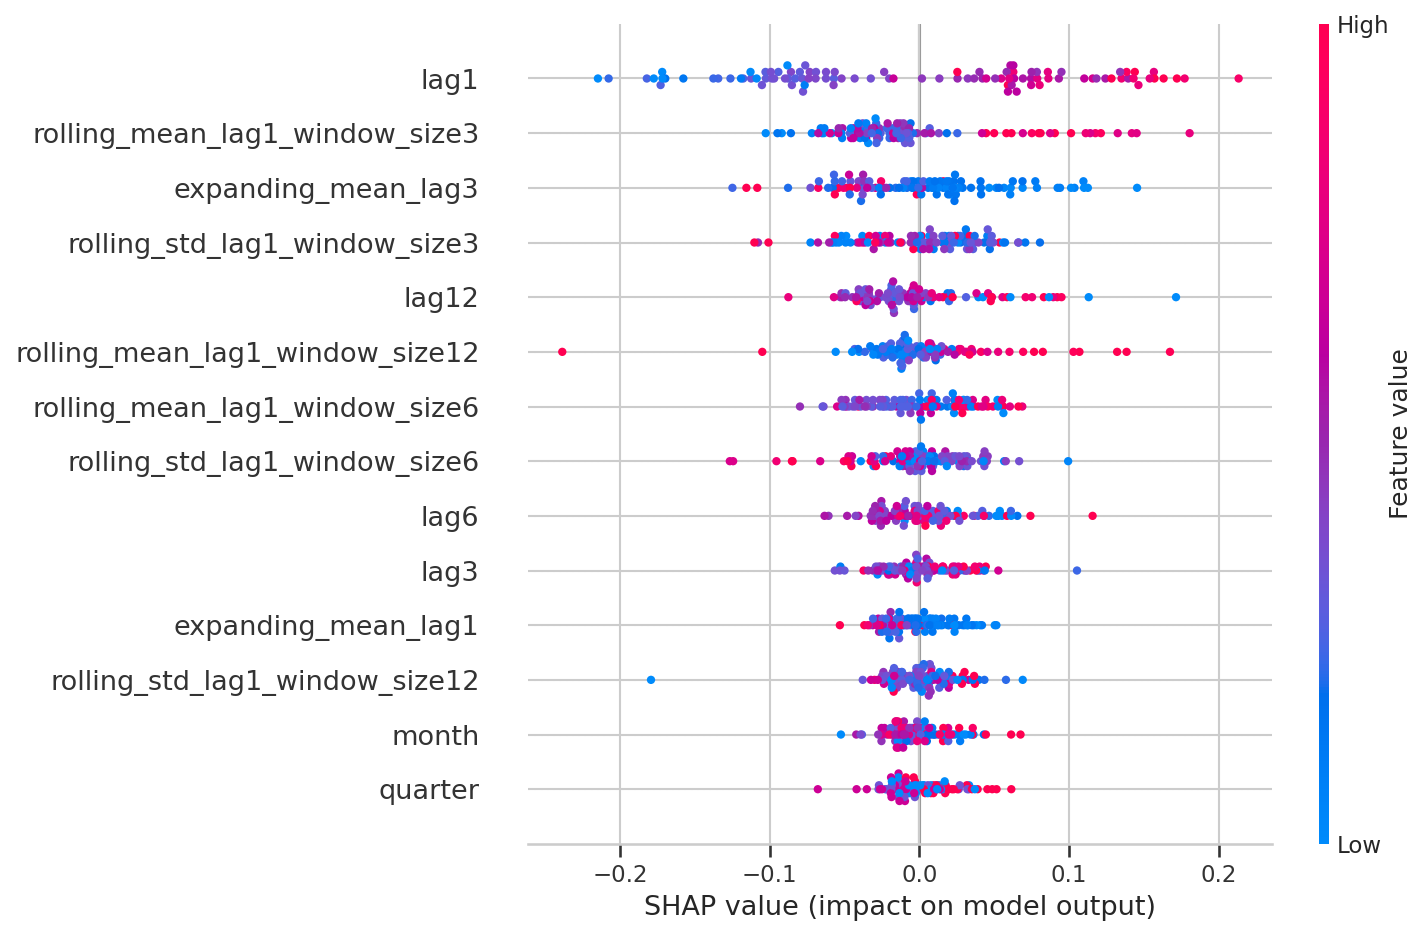

In [63]:
# pre-proc the df_train
df_train_prep, _ = fcst.preprocess(df_train, return_X_y=True)

# Get the catboost model
model = fcst.models_['CatBoostRegressor']

# Getting the SHAP values from the LGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_train_prep)
shap.plots.beeswarm(shap_values, max_display=25)


In [64]:
print('Max date:', df['ds'].max())
print('Min date:', df['ds'].min())

Max date: 2025-04-01 00:00:00
Min date: 2015-01-01 00:00:00


In [65]:
levels = [90, 95]
predictions = fcst.predict(11, level=levels, X_df=df_test)

In [66]:
predictions.head()

,unique_id,ds,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,1,2024-06-01,0.620248,0.178674,0.237786,1.002710,1.061822
1,1,2024-07-01,0.547555,-0.807325,-0.700306,1.795415,1.902435
2,1,2024-08-01,0.463681,-0.429363,-0.362088,1.289450,1.356726
3,1,2024-09-01,0.454596,-0.480506,-0.455875,1.365067,1.389698
4,1,2024-10-01,0.419345,-0.513583,-0.389362,1.228052,1.352273


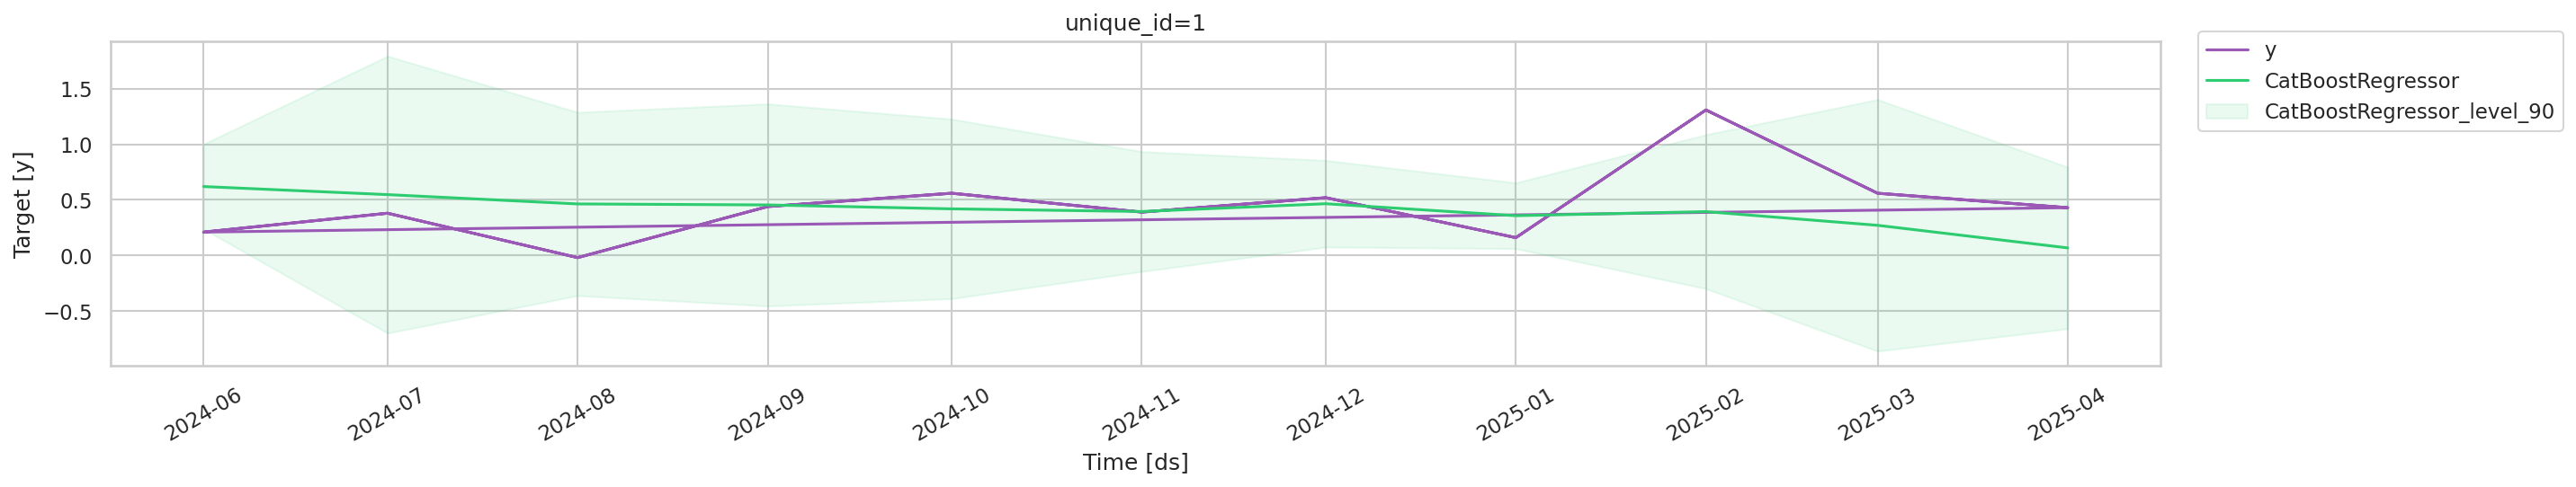

In [67]:
# Merge the test dateset with all predictions
test_df_final = df_test.merge(predictions, how='left', on=['unique_id', 'ds'])

# Plot the model forecasting
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    level=[90],
    max_insample_length=2000,
    models=['CatBoostRegressor'],
)
fig



In [68]:
metrics = [
    mape,
    mae,
    coverage
]

results = evaluate(test_df_final, metrics, level=[90])
results

,unique_id,metric,CatBoostRegressor
0,1,mape,2.752333
1,1,mae,0.276512
2,1,coverage_level90,0.818182
